# Seção 20.01 - Agrupamento com K-means (Análise de crédito) (Online Shoppers Purchasing Intention)
Para esta seção, usarei a base de dados "Online Shoppers Purchasing Intention" disponibilizada no [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset).

Fonte: [Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018)](https://link.springer.com/article/10.1007%2Fs00521-018-3523-0).

<img src="../imagens/kmeans_tipoAprendizado.png" alt="Tipos de Aprendizados Clássicos" width="600"/>
<p style="text-align:center">Figura 01 - Tipos de aprendizados clássicos.</p>
<p style="text-align:center">Fonte: Aula da Tera. Professora VIVIAN YAMASSAKI.</p>

In [10]:
# Instruções basiconas de sempre.

# Lidar com dataframes.
import numpy as np
import pandas as pd

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns

# Lidar com preparação de dados.
from data_prep import data_prep as dp # Eu que fiz esse modulinho ("uuuuuuuuuma bosts!").
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split
                                     , cross_val_score
                                     , StratifiedKFold
                                     , cross_val_score)

# Lidar com validação de modelos.
from sklearn.metrics import (confusion_matrix
                             , accuracy_score
                             , classification_report)

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 4)

## Avaliação da base

In [11]:
nomeDaBase = "../../bases/online_shoppers_intention/online_shoppers_intention.csv"
df = pd.read_csv(nomeDaBase, sep=",", encoding="utf-8")

df.sample(4).T

,9192,216,8339,1821
Administrative,5,2,3,0
Administrative_Duration,126.2,118,65,0
Informational,0,0,0,0
Informational_Duration,0,0,0,0
ProductRelated,15,4,29,2
ProductRelated_Duration,286.5,42,386.3,5
BounceRates,0.005263,0,0,0
ExitRates,0.01754,0.06667,0.0006667,0.1
PageValues,0,0,0,0
SpecialDay,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [5]:
df_temporario = df.select_dtypes(include=["float64"])
df_temporario.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157213,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


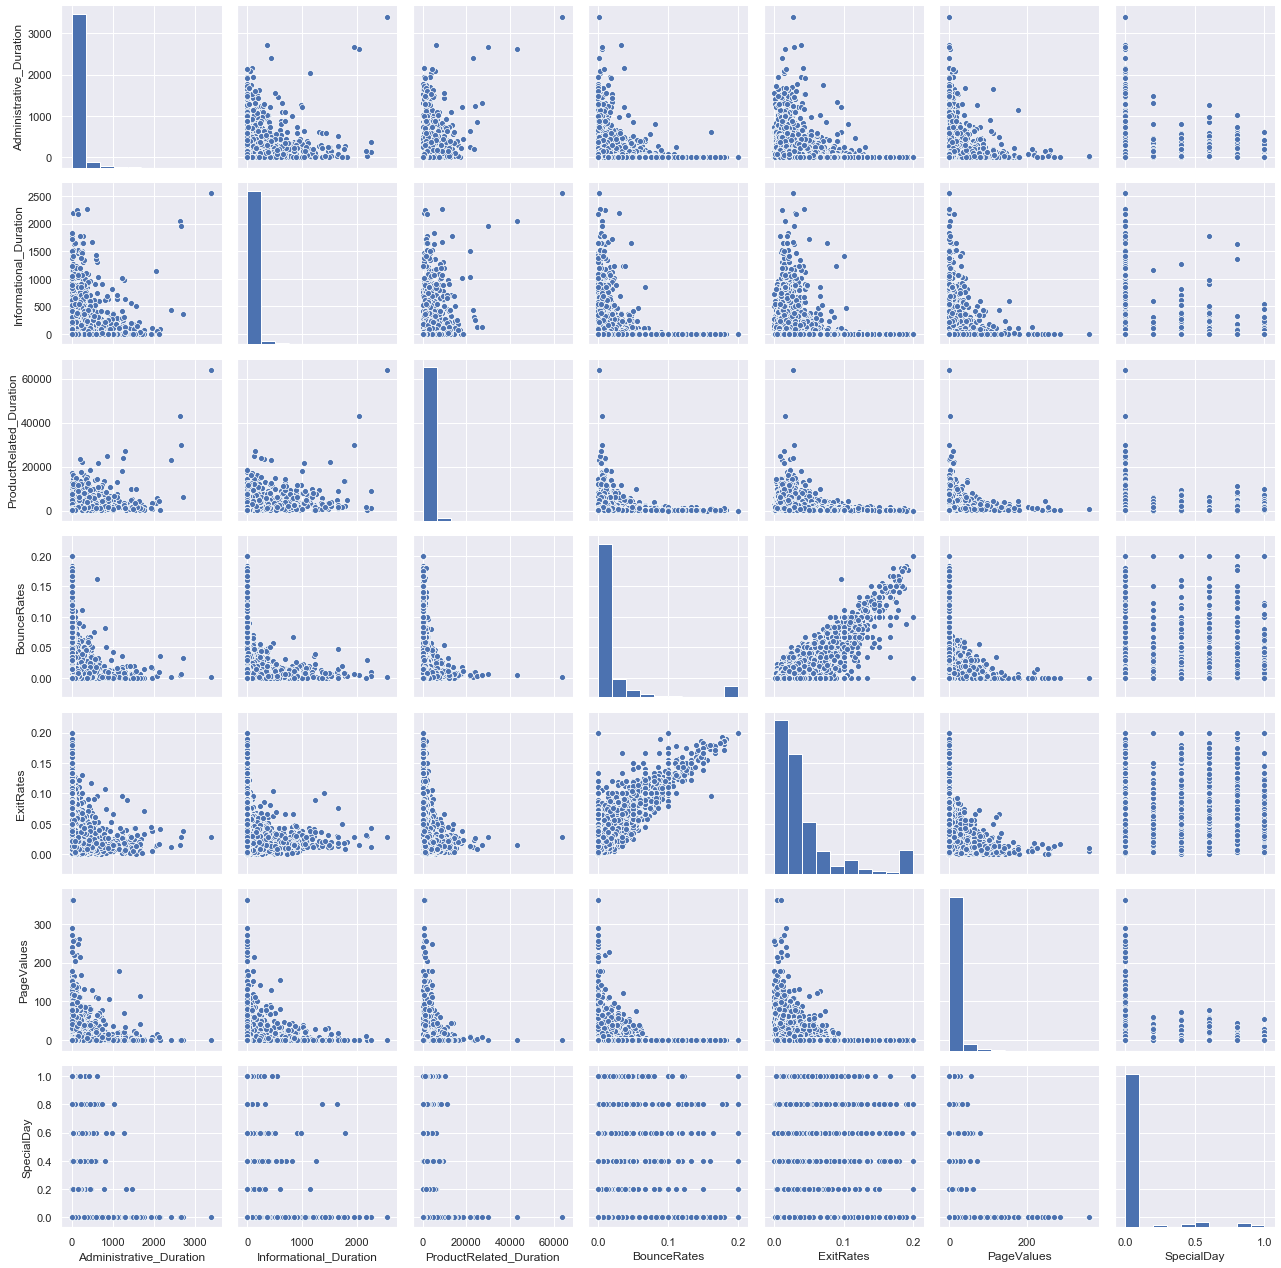

In [6]:
sns.set(style="darkgrid")

lista_atributos = list(df_temporario.columns)
lista_atributos.append("Revenue")

sns.pairplot(df[df_temporario.columns]
             , kind="scatter"
             , markers=["o"]
             , palette="Set2"
             , 
            )
plt.show();

In [7]:
df_temporario = df.select_dtypes(exclude=["float64"])

matriz_cardialidade = []

for i, coluna in df_temporario.items():
    matriz_cardialidade.append([i, len(df_temporario[i].unique()), df_temporario[i].unique()])

matriz_cardialidade = pd.DataFrame(matriz_cardialidade, columns=["Atributo", "Cardinalidade", "Valores"])
matriz_cardialidade.sort_values(by="Cardinalidade", inplace=True, ascending=True)

matriz_cardialidade

,Atributo,Cardinalidade,Valores
9,Weekend,2,"[False, True]"
10,Revenue,2,"[False, True]"
8,VisitorType,3,"[Returning_Visitor, New_Visitor, Other]"
4,OperatingSystems,8,"[1, 2, 4, 3, 7, 6, 8, 5]"
6,Region,9,"[1, 9, 2, 3, 4, 5, 6, 7, 8]"
3,Month,10,"[Feb, Mar, May, Oct, June, Jul, Aug, Nov, Sep, Dec]"
5,Browser,13,"[1, 2, 3, 4, 5, 6, 7, 10, 8, 9, 12, 13, 11]"
1,Informational,17,"[0, 1, 2, 4, 16, 5, 3, 14, 6, 12, 7, 9, 10, 8, 11, 24, 13]"
7,TrafficType,20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 16, 17, 20]"
0,Administrative,27,"[0, 1, 2, 4, 12, 3, 10, 6, 5, 9, 8, 16, 13, 11, 7, 18, 14, 17, 19, 15, 24, 22, 21, 20, 23, 27, 26]"


### Problemas encontrados na base:

1. Não foram encontradas falhas ou dados inconsistentes na base.
2. **Porém, um ponto importante:** Futuramenete, eu DEVO implementar um método para retornar a proporção de cada categoria. 
3. Considerando os atributos contínuos, vemos que há uma correlação positiva entre *BounceRates* e *ExitRates*. **Precisamos avaliar melhor e verificar se isso realmente tem relação.** 


**IMPORTANTE!** O atributo *Revenue* é a classe / resposta / variável alvo deste dataset. Vou usar essa classe para "colorir" os gráficos e poderemos usar essas cores para entender se há um comportamento diferente entre usuários compradores (*Revenue* = True) e não compradores (*Revenue* = False). 

# Transformando os dados

## Normatizando / escalonando os dados

In [9]:
# Para normatizar/normalizar/escalonar os dados, usaremos o StandardScaler:

scaler = StandardScaler()
df_tratado.iloc[:,0:3] = scaler.fit_transform(df_tratado.iloc[:,0:3])

In [10]:
df_tratado.describe()

,income,age,loan,default
count,2.000000e+03,2.000000e+03,2.000000e+03,2000.000000
mean,4.451994e-17,-5.861978e-17,1.398881e-16,0.141500
std,1.000250e+00,1.000250e+00,1.000250e+00,0.348624
min,-1.767616e+00,-1.726415e+00,-1.459279e+00,0.000000
25%,-8.751912e-01,-8.925908e-01,-8.226437e-01,0.000000
50%,3.194341e-02,2.815472e-02,-1.542543e-01,0.000000
75%,8.699227e-01,8.796913e-01,6.529624e-01,0.000000
max,1.722022e+00,1.739367e+00,3.061661e+00,1.000000


# Aplicação do k-means

O principal argumento (e também fraqueza) do modelo k-means (e, também, do k-medians) é a indicação a priori da quantidade de clusters. Portanto, faremos duas abordagens: (1) definição arbitrária da quantidade de clusters e (2) definição da quantidade ideal de clusters através da curva de entropia vs n.º clusters.

### 2.1) Simplesmente aplicando o K-means com split test e depois validação cruzada

In [11]:
# Separando os fatores/previsores da resposta/target:
    
x = df_tratado.iloc[:, 0:3]
y = df_tratado.iloc[:, 3]

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.cluster import KMeans
classificador = KMeans(n_clusters=2,
                      random_state=42)
classificador.fit(x_train, y_train)
y_pred = classificador.predict(x_test)

### Plotando o gráfico

In [40]:
plt.rcParams['figure.figsize'] = (12, 7)

In [41]:
# salva os centroides
centroides = classificador.cluster_centers_
# salva as labels dos clusters para cada exemplo
y_kmeans = classificador.predict(x)

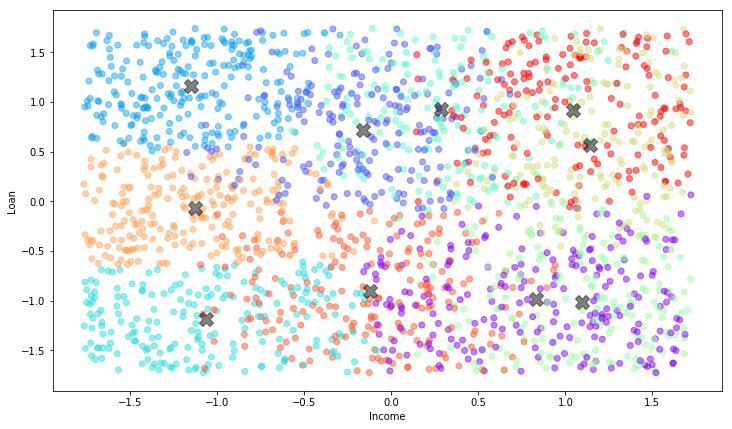

In [43]:
# plota os dados identificando seus clusters
plt.scatter(df_tratado.income, df_tratado.age, c = y_kmeans, alpha = 0.5, cmap = 'rainbow')
plt.xlabel('Income')
plt.ylabel('Loan')
# plota os centroides também
plt.scatter(centroides[:, 0], centroides[:, 1], c='black', marker='X', s=200, alpha=0.5)
plt.show()

### 2.2) Agora, avaliando a quantidade de clusteres ideal

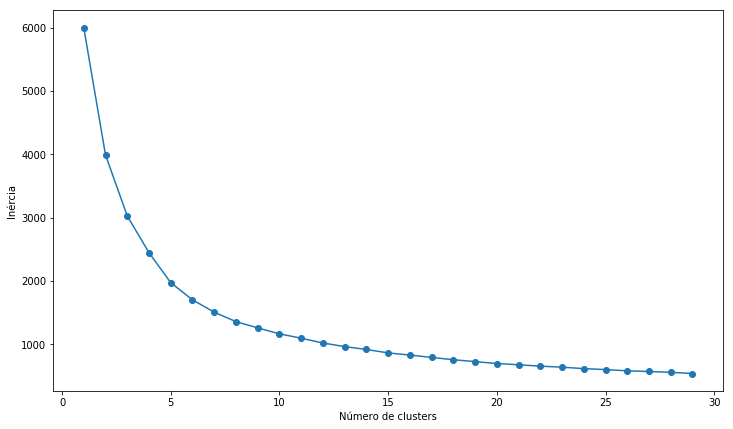

In [44]:
# Quantidade de clusters que serão testados
k = list(range(1, 30))

# Armazena das inércias para cada k
inercia = []

# Roda o K-means para cada k fornecido
for i in k:
    classificador = KMeans(n_clusters=i)
    classificador.fit(x)
    inercia.append(classificador.inertia_)

# Plota o gráfico com as inércias
plt.plot(k, inercia, '-o')
plt.xlabel(r'Número de clusters')
plt.ylabel('Inércia')
plt.show()

In [37]:
classificador = KMeans(n_clusters=10,
                      random_state=42)
classificador.fit(x_train, y_train)
y_pred = classificador.predict(x_test)

### Plotando o gráfico

In [38]:
# salva os centroides
centroides = classificador.cluster_centers_
# salva as labels dos clusters para cada exemplo
y_kmeans = classificador.predict(x)

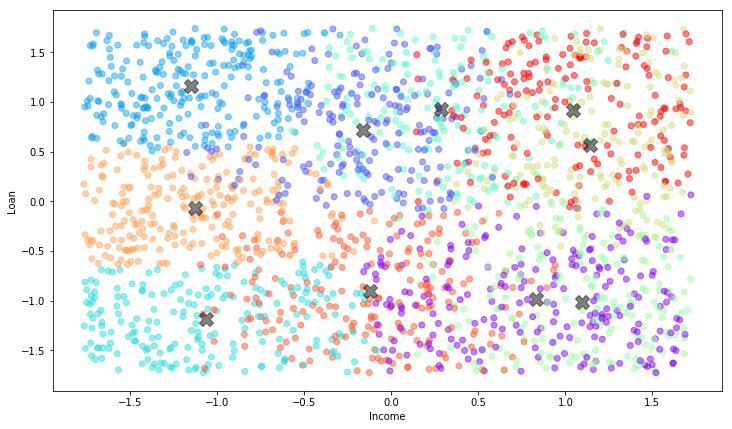

In [45]:
# plota os dados identificando seus clusters
plt.scatter(df_tratado.income, df_tratado.age, c = y_kmeans, alpha = 0.5, cmap = 'rainbow')
plt.xlabel('Income')
plt.ylabel('Loan')
# plota os centroides também
plt.scatter(centroides[:, 0], centroides[:, 1], c='black', marker='X', s=200, alpha=0.5)
plt.show()